In [1]:
from drn_interactions.interactions.loaders import SpontaneousActivityLoader, StateInteractionsLoader
from drn_interactions.interactions.preprocessors import InteractionsPreprocessor
from drn_interactions.interactions.pairwise import PairwiseCorr
from drn_interactions.interactions.graph_clustering import df_to_graph
from karateclub.graph_embedding import FeatherGraph, FGSD, Graph2Vec, NetLSD, SF, IGE
from drn_interactions.config import Config, ExperimentInfo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
import numpy as np
from drn_interactions.io import load_derived_generic

In [3]:
sessions = ExperimentInfo.eeg_sessions


graphs = []

node_mappers = []
target = []
for state in ("sw", "act"):
    for session in sessions:
        loader = StateInteractionsLoader(state=state, session_name=session, block="pre", t_start=0, t_stop=1800)
        preprocessor = InteractionsPreprocessor()
        pairwise = PairwiseCorr(rectify=True)

        spikes = preprocessor(loader())
        df_affinity = pairwise.fit(spikes).get_adjacency_df().dropna(axis=1, thresh=5).dropna(axis=0, thresh=5)
        G = df_to_graph(df_affinity, rename_nodes=False)
        node_mappers.append({node: neuron for node, neuron in enumerate(df_affinity.columns)})
        graphs.append(G)
        target.append(state)

0.7999999999999999


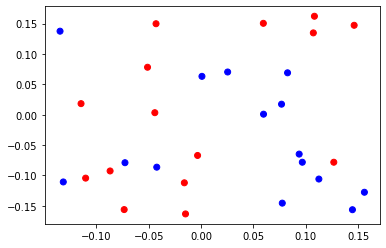

In [9]:
# embedding
from sklearn.model_selection import cross_val_score, KFold

# mod = FeatherGraph(eval_points=20)
mod = Graph2Vec(dimensions=6)
# mod = FeatherGraph(eval_points=20)

mod.fit(graphs)
X = mod.get_embedding()
y = LabelEncoder().fit_transform(target)

# clf = SVC(kernel="rbf", C=1)
clf = DecisionTreeClassifier(max_depth=10)
# clf = LogisticRegressionCV()

score = cross_val_score(clf, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))
print(score.mean())

c = np.where(y == 0, "red", "blue")

plt.scatter(X[:, 1], X[:, 3], c=c)

In [11]:
from drn_interactions.interactions.loaders import BaseShockSlowInteractionsLoader

sessions = ExperimentInfo.foot_shock_sessions_10min
graphs = []

node_mappers = []
target = []
for block in ("pre", "base_shock", "post_base_shock"):
    for session in sessions:
        loader = BaseShockSlowInteractionsLoader(block=block, session_name=session)
        preprocessor = InteractionsPreprocessor(loader)
        pairwise = PairwiseCorr(rectify=True)

        spikes = preprocessor(loader())
        df_affinity = pairwise.fit(spikes).get_adjacency_df()
        G = df_to_graph(df_affinity, rename_nodes=False)
        node_mappers.append({node: neuron for node, neuron in enumerate(df_affinity.columns)})
        graphs.append(G)
        target.append(block)

0.47000000000000003


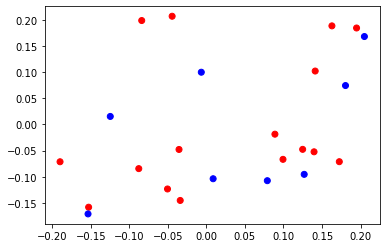

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

mod = Graph2Vec(dimensions=5)

mod.fit(graphs)
X = mod.get_embedding()
# y = LabelEncoder().fit_transform(target)
y = LabelEncoder().fit_transform(np.where(np.array(target) != "base_shock", "baseline", "shock"))

# clf = SVC(kernel="rbf", C=1)
clf = DecisionTreeClassifier(max_depth=10)
# clf = LogisticRegressionCV()

score = cross_val_score(clf, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))
print(score.mean())

c = np.where(y == 0, "red", "blue")
plt.scatter(X[:, 0], X[:, 1], c=c)